In [1]:
# (Run once if needed)
%pip -q install --upgrade pandas numpy scikit-learn matplotlib seaborn joblib boto3


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1) Data Loading & Inspection

In [2]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

# Optional (only if loading from S3)
import boto3
import io

# Plot style & reproducibility
sns.set_theme(context="notebook", style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 120)


In [3]:
DATA_SOURCE = "local"

# Set these if using S3
S3_BUCKET = "blocket-lake--eun1-az1--x-s3"
S3_KEY = "/car_features.csv"

if DATA_SOURCE == "s3":
    s3 = boto3.client("s3")
    obj = s3.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
    df = pd.read_csv(io.BytesIO(obj["Body"].read()))
else:
    # Local CSV path (adjust as needed)
    CSV_PATH = "cars.csv"
    df = pd.read_csv(CSV_PATH)

print(df.shape)
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(20))
df.info()


(33666, 19)


,ad_id,price,subject,brand,model,model_family,model_year,mileage,fuel,gearbox,horsepower,color,drive_wheels,body_type,first_traffic_date,equipment_count,advertiser_type,region,municipality
0,1000093175,1.0,Morgan Plus andra engelska klassiker önskas k...,Morgan,Plus,NaN,2010.0,0,NaN,NaN,NaN,NaN,NaN,Cab,NaN,0,store,Älvsborg,Lerum
1,1000096100,185000.0,Mercedes-Benz ML 350 BlueTEC 4MATIC 7G-Tronic ...,Mercedes-Benz,ML,ML,2014.0,21 700,Diesel,Automat,258.0,Silver,Fyrhjulsdriven,SUV,2013-09-27,61,store,Västerbotten,Umeå
2,1000096500,84900.0,Volkswagen Touran 1.4 TSI EcoFuel 150hk&Drag&B...,Volkswagen,Touran,Touran,2012.0,14 000,Miljöbränsle/Hybrid,Manuell,150.0,Röd,Tvåhjulsdriven,Familjebuss,2011-10-31,36,store,Kalmar,Nybro
3,1000097780,39500.0,Peugeot 207 3-dörrar 1.6 Sport 109hk,Peugeot,207,207,2007.0,8 946,Bensin,Manuell,109.0,Ljusgrå (Grå),Tvåhjulsdriven,Halvkombi,2007-04-16,27,store,Skaraborg,Mariestad
4,1000098528,959000.0,"Mercedes-Benz EQS 450 108 kWh, 333hk Moms",Mercedes-Benz,EQS,EQS,2023.0,1 820,El,Automat,333.0,Svart,Tvåhjulsdriven,Halvkombi,2022-08-22,58,store,Skåne,Lund


first_traffic_date    0.402364
color                 0.297214
drive_wheels          0.291956
mileage               0.131557
horsepower            0.088903
municipality          0.030743
model_family          0.023406
body_type             0.017674
gearbox               0.009891
fuel                  0.008406
model                 0.004812
brand                 0.001455
price                 0.000802
model_year            0.000683
subject               0.000653
advertiser_type       0.000653
ad_id                 0.000000
equipment_count       0.000000
region                0.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33666 entries, 0 to 33665
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               33666 non-null  int64  
 1   price               33639 non-null  float64
 2   subject             33644 non-null  object 
 3   brand               33617 non-null  object 
 4   model               33504 non-null  object 
 5   model_family        32878 non-null  object 
 6   model_year          33643 non-null  float64
 7   mileage             29237 non-null  object 
 8   fuel                33383 non-null  object 
 9   gearbox             33333 non-null  object 
 10  horsepower          30673 non-null  float64
 11  color               23660 non-null  object 
 12  drive_wheels        23837 non-null  object 
 13  body_type           33071 non-null  object 
 14  first_traffic_date  20120 non-null  object 
 15  equipment_count     33666 non-null  int64  
 16  adve

# 2) Data Cleaning & Preparation

In [4]:
df = df.drop(columns=["ad_id"], errors="ignore")

def to_float_or_nan(x):
    if pd.isna(x): 
        return np.nan
    s = re.sub(r"[^\d]", "", str(x))
    return float(s) if s else np.nan


if "mileage" in df.columns:
    df["mileage"] = df["mileage"].apply(to_float_or_nan)

for col in ["model_year", "horsepower", "equipment_count"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

if "first_traffic_date" in df.columns:
    df["first_traffic_date"] = pd.to_datetime(df["first_traffic_date"], errors="coerce")

df = df[df["price"].notnull()]

cat_cols_all = [
    "brand", "model", "model_family", "fuel", "gearbox", "color",
    "drive_wheels", "body_type", "advertiser_type", "region", "municipality"
]
for c in cat_cols_all:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")


# 3) Feature Engineering

In [5]:
today = pd.Timestamp.today().normalize()

if "model_year" in df.columns:
    df["vehicle_age"] = today.year - df["model_year"]

# Days since first traffic date
if "first_traffic_date" in df.columns:
    df["days_since_first_traffic"] = (today - df["first_traffic_date"]).dt.days

# Location combo
if {"region","municipality"}.issubset(df.columns):
    df["region_municipality"] = df["region"].astype(str) + " | " + df["municipality"].astype(str)

# Subject length
if "subject" in df.columns:
    df["subject_len"] = df["subject"].astype(str).str.len()

# Target transform (log)
df["price_log"] = np.log1p(df["price"].astype(float))

display(df.head())


,price,subject,brand,model,model_family,model_year,mileage,fuel,gearbox,horsepower,color,drive_wheels,body_type,first_traffic_date,equipment_count,advertiser_type,region,municipality,vehicle_age,days_since_first_traffic,region_municipality,subject_len,price_log
0,1.0,Morgan Plus andra engelska klassiker önskas k...,Morgan,Plus,Unknown,2010.0,0.0,Unknown,Unknown,NaN,Unknown,Unknown,Cab,NaT,0,store,Älvsborg,Lerum,15.0,NaN,Älvsborg | Lerum,50,0.693147
1,185000.0,Mercedes-Benz ML 350 BlueTEC 4MATIC 7G-Tronic ...,Mercedes-Benz,ML,ML,2014.0,21700.0,Diesel,Automat,258.0,Silver,Fyrhjulsdriven,SUV,2013-09-27,61,store,Västerbotten,Umeå,11.0,4413.0,Västerbotten | Umeå,60,12.128117
2,84900.0,Volkswagen Touran 1.4 TSI EcoFuel 150hk&Drag&B...,Volkswagen,Touran,Touran,2012.0,14000.0,Miljöbränsle/Hybrid,Manuell,150.0,Röd,Tvåhjulsdriven,Familjebuss,2011-10-31,36,store,Kalmar,Nybro,13.0,5110.0,Kalmar | Nybro,60,11.349241
3,39500.0,Peugeot 207 3-dörrar 1.6 Sport 109hk,Peugeot,207,207,2007.0,8946.0,Bensin,Manuell,109.0,Ljusgrå (Grå),Tvåhjulsdriven,Halvkombi,2007-04-16,27,store,Skaraborg,Mariestad,18.0,6769.0,Skaraborg | Mariestad,36,10.584081
4,959000.0,"Mercedes-Benz EQS 450 108 kWh, 333hk Moms",Mercedes-Benz,EQS,EQS,2023.0,1820.0,El,Automat,333.0,Svart,Tvåhjulsdriven,Halvkombi,2022-08-22,58,store,Skåne,Lund,2.0,1162.0,Skåne | Lund,41,13.773647


# 4) Outlier Detection & Handling

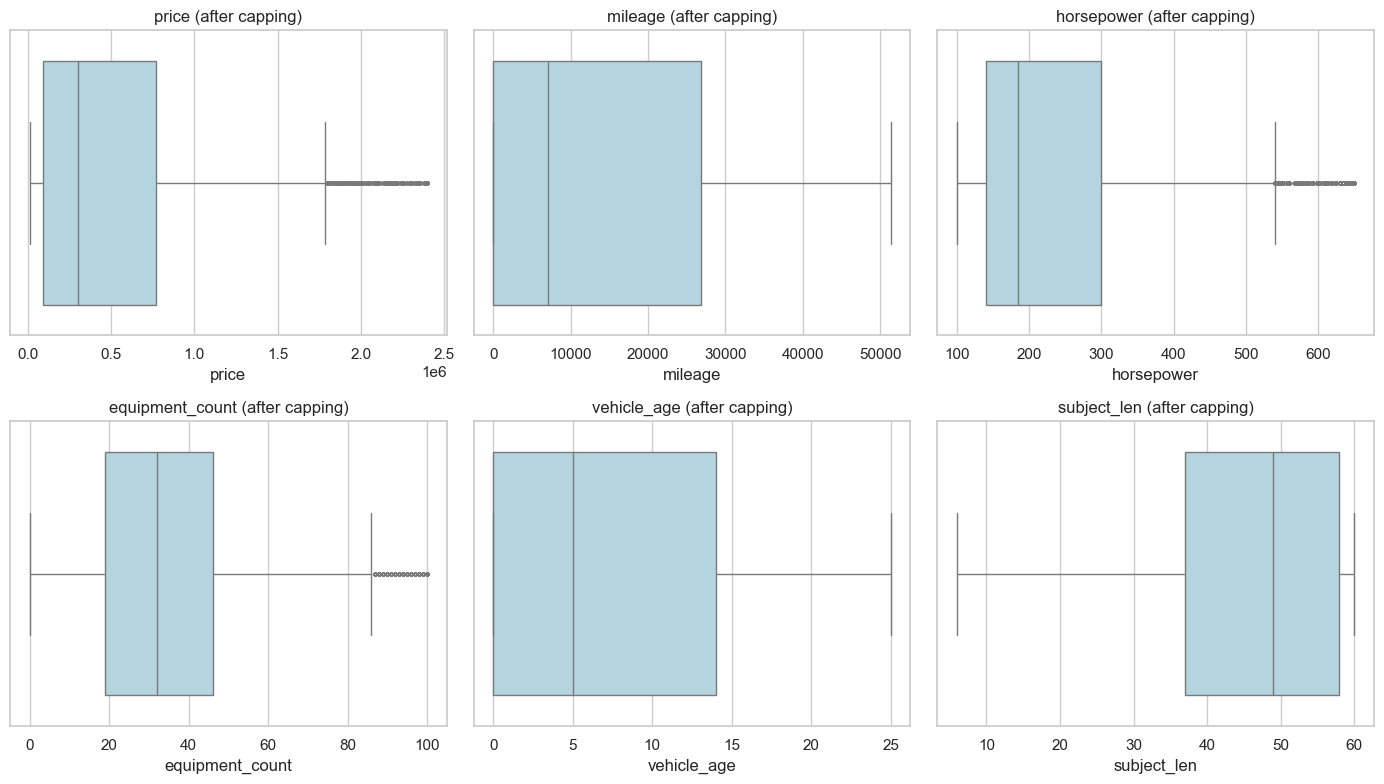

In [6]:
# ===== 4) Outlier Handling =====

# Optional: remove obvious non-sale rows (e.g., leasing/monthly promos)
df = df[df["price"] >= 10_000]

# Clip unrealistic entries to reasonable bounds
if "model_year" in df.columns:
    df["model_year"] = df["model_year"].clip(lower=2000, upper=today.year + 1)
if "horsepower" in df.columns:
    df["horsepower"] = df["horsepower"].clip(lower=100, upper=800)
if "vehicle_age" in df.columns:
    df["vehicle_age"] = df["vehicle_age"].clip(lower=0, upper=25)
if "equipment_count" in df.columns:
    df["equipment_count"] = df["equipment_count"].clip(lower=0, upper=150)

# Percentile capping function (robust and simple)
def cap_outliers(series, lower_q=0.01, upper_q=0.99):
    lo, hi = series.quantile(lower_q), series.quantile(upper_q)
    return series.clip(lo, hi)

num_for_capping = [c for c in ["price","mileage","horsepower","equipment_count","vehicle_age"] if c in df.columns]
for c in num_for_capping:
    df[c] = cap_outliers(df[c], 0.01, 0.99)

# Optional: log of mileage (skew reduction)
if "mileage" in df.columns:
    df["mileage_log"] = np.log1p(df["mileage"])

# Quick sanity visuals (boxplots)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.ravel()
plot_cols = [c for c in ["price","mileage","horsepower","equipment_count","vehicle_age","subject_len"] if c in df.columns]
for i, c in enumerate(plot_cols):
    sns.boxplot(x=df[c], color="lightblue", ax=axes[i], fliersize=2)
    axes[i].set_title(f"{c} (after capping)")
plt.tight_layout()
plt.show()


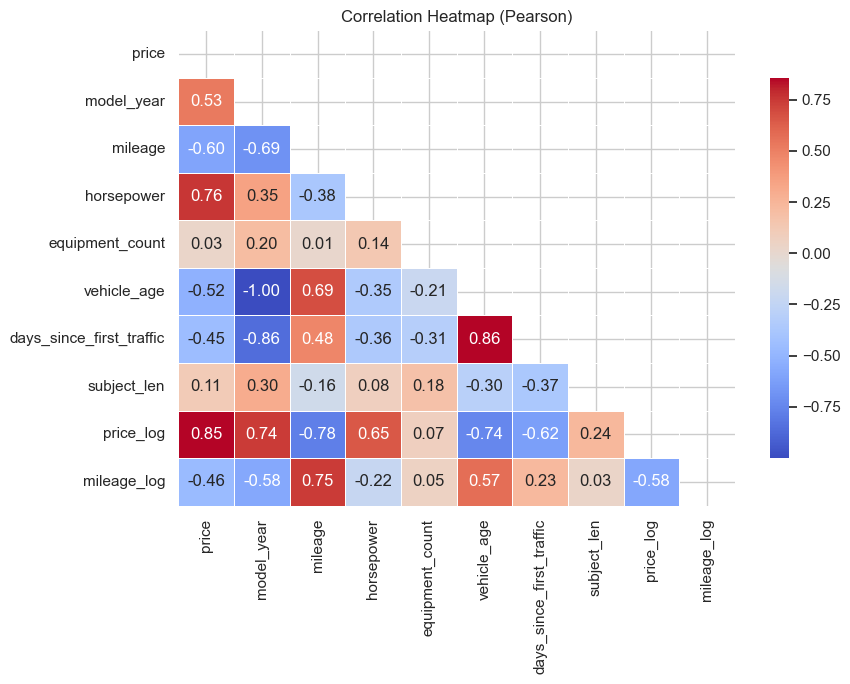

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pick only numeric columns
num_df = df.select_dtypes(include=["number"]).copy()

# Optional: choose what to include (uncomment to focus)
# keep_cols = ["price","price_log","mileage","mileage_log","horsepower",
#              "equipment_count","vehicle_age","days_since_first_traffic","subject_len"]
# num_df = num_df[[c for c in keep_cols if c in num_df.columns]]

corr = num_df.corr(method="pearson")

# Mask upper triangle for a cleaner look
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(9,7))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()


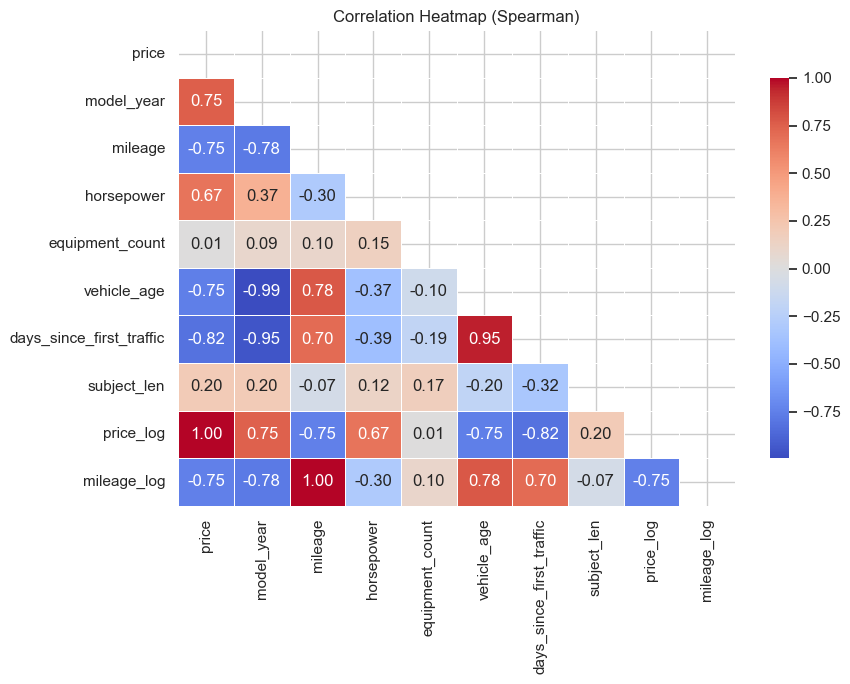

In [8]:
corr_s = num_df.corr(method="spearman")
mask = np.triu(np.ones_like(corr_s, dtype=bool))

plt.figure(figsize=(9,7))
sns.heatmap(
    corr_s, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap (Spearman)")
plt.tight_layout()
plt.show()


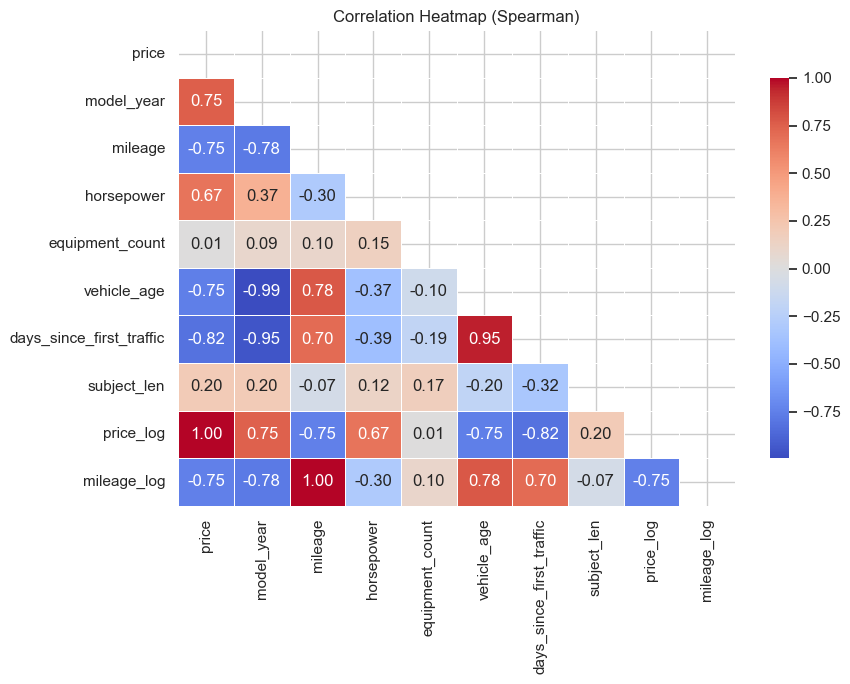

In [9]:
corr_s = num_df.corr(method="spearman")
mask = np.triu(np.ones_like(corr_s, dtype=bool))

plt.figure(figsize=(9,7))
sns.heatmap(
    corr_s, mask=mask, annot=True, fmt=".2f",
    cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap (Spearman)")
plt.tight_layout()
plt.show()


In [10]:
df = df.drop(columns=[
    "price", "mileage", "model_year", "days_since_first_traffic"
], errors="ignore")

In [15]:
df.head()

,subject,brand,model,model_family,fuel,gearbox,horsepower,color,drive_wheels,body_type,first_traffic_date,equipment_count,advertiser_type,region,municipality,vehicle_age,region_municipality,subject_len,price_log,mileage_log
1,Mercedes-Benz ML 350 BlueTEC 4MATIC 7G-Tronic ...,Mercedes-Benz,ML,ML,Diesel,Automat,258.0,Silver,Fyrhjulsdriven,SUV,2013-09-27,61,store,Västerbotten,Umeå,11.0,Västerbotten | Umeå,60,12.128117,9.985114
2,Volkswagen Touran 1.4 TSI EcoFuel 150hk&Drag&B...,Volkswagen,Touran,Touran,Miljöbränsle/Hybrid,Manuell,150.0,Röd,Tvåhjulsdriven,Familjebuss,2011-10-31,36,store,Kalmar,Nybro,13.0,Kalmar | Nybro,60,11.349241,9.546884
3,Peugeot 207 3-dörrar 1.6 Sport 109hk,Peugeot,207,207,Bensin,Manuell,109.0,Ljusgrå (Grå),Tvåhjulsdriven,Halvkombi,2007-04-16,27,store,Skaraborg,Mariestad,18.0,Skaraborg | Mariestad,36,10.584081,9.099074
4,"Mercedes-Benz EQS 450 108 kWh, 333hk Moms",Mercedes-Benz,EQS,EQS,El,Automat,333.0,Svart,Tvåhjulsdriven,Halvkombi,2022-08-22,58,store,Skåne,Lund,2.0,Skåne | Lund,41,13.773647,7.507141
5,Renault Kangoo E-Tech Skåp 45kWh Nordic L1 II,Renault,Kangoo,Kangoo,El,Automat,124.0,Grå,Tvåhjulsdriven,Yrkesfordon,2024-08-28,11,store,Örebro,Karlskoga,2.0,Örebro | Karlskoga,45,12.871337,0.000000


# 5) Data Splitting & Preprocessing

In [17]:

features = [
    # numeric
    "mileage_log" if "mileage_log" in df.columns else "mileage",
    "horsepower", "equipment_count", "vehicle_age", "days_since_first_traffic", "subject_len",
    # categorical
    "brand", "model", "model_family", "fuel", "gearbox", "color",
    "drive_wheels", "body_type", "advertiser_type", "region", "municipality", "region_municipality"
]
features = [f for f in features if f in df.columns]  # keep existing only

X = df[features].copy()
y = df["price_log"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# IMPORTANT: make OneHot dense for HistGradientBoosting
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # use sparse=False if sklearn <1.2

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
], remainder="drop")


# 6) Modeling & Evaluation

In [18]:
model = HistGradientBoostingRegressor(
    learning_rate=0.06,
    max_iter=1000,
    early_stopping=True,
    random_state=RANDOM_STATE,
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model),
])

pipe.fit(X_train, y_train)
print("✅ Model trained!")

# Evaluate
y_pred_log = pipe.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE : {mae:,.0f} SEK")
print(f"RMSE: {rmse:,.0f} SEK")
print(f"R²  : {r2:.3f}")


✅ Model trained!
MAE : 78,005 SEK
RMSE: 245,516 SEK
R²  : 0.776


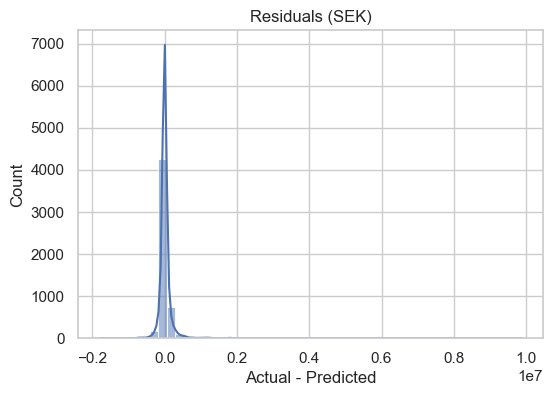

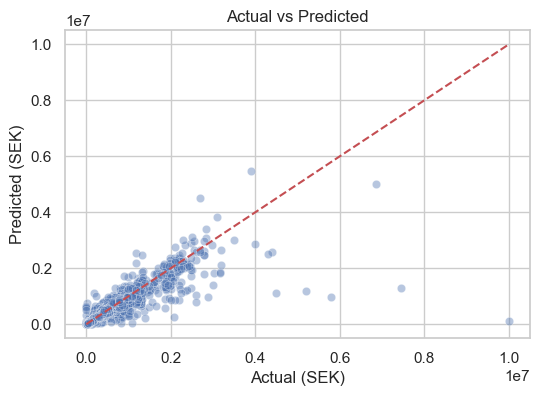

In [13]:
resid = y_true - y_pred
plt.figure(figsize=(6,4))
sns.histplot(resid, bins=50, kde=True)
plt.title("Residuals (SEK)")
plt.xlabel("Actual - Predicted")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual (SEK)")
plt.ylabel("Predicted (SEK)")
plt.title("Actual vs Predicted")
plt.show()


In [14]:
import joblib

# Save the model (replace 'model' with your actual model variable name)
# If you're using a pipeline, use that variable name instead
joblib.dump(model, 'model.pkl')

print("Model saved successfully to model.pkl")

Model saved successfully to model.pkl
